# Predicting Stock Market Prices

## Introduction
In this guided project, we will work with data from the S&P 500 Index. The goal of this project is to build a linear regression model to predict future prices. With these future prices, it can help us forecast how the stock market performs as a whole and even with economic forecasts (since the economy tends to correlate with how well the stock market performs). 

## About the data
The columns of the dataset are:

- `Date` : The date of the record.
- `Open` : The opening price of the day (when trading starts).
- `High` : The highest trade price during the day.
- `Low` : The lowest trade price during the day.
- `Close` : The closing price for the day (when trading is finished).
- `Volume` : The number of shares traded.
- `Adj Close` : The daily closing price, adjusted retroactively to include any corporate actions. 


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
stocks = pd.read_csv("sphist.csv")

## Explore the data

In [3]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


In [4]:
stocks

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883
...,...,...,...,...,...,...,...
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2.520000e+06,17.080000
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2.010000e+06,16.980000
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2.550000e+06,16.930000
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1.890000e+06,16.850000


Let's flip the data frame so the most recent stock price is at the bottom of the dataframe.

In [5]:
stock_prices = stocks.iloc[stocks.index[::-1]].reset_index(drop=True).copy()

In [6]:
# Change `Date` column to datetime 
stock_prices["Date"] = pd.to_datetime(stock_prices["Date"])

## Make sure each date is a weekday

In [7]:
# Make sure each date is a trading day/weekday because you can only trade during the weekdays in the stock market

# Returns boolean. 1 = date is a weekday, 0 = not a weekday
stock_prices["Weekday"] = (((stock_prices["Date"]).dt.dayofweek) // 5 < 1).astype(float)
stock_prices["Weekday"].value_counts(dropna=False)

1.0    16590
Name: Weekday, dtype: int64

## Creating new indicators with the data given

Since we're trying to predict the closing price, let's generate the average closing price for the past 5, 30, and 365 business days. To not inject future knowledge into our model, these metrics will not include the current day. 

For example, on 2015-12-07, we want to know the average closing price for the past 5 days. We will calculate the average for 2015-12-04, 2015-12-03, 2015-12-02, 2015-12-01, and 2015-11-30. 

In [8]:
def calc_past_days(df, col, days, func):
    
    if func == "mean":
        result = df[col].rolling(days).mean().shift(1)
    elif func == "std":
        result = df[col].rolling(days).std().shift(1)
        
    return result

# Averages for the past 5, 30, and 365 days
stock_prices["avg_last5"] = calc_past_days(stock_prices, "Close", 5, "mean")
stock_prices["avg_last30"] = calc_past_days(stock_prices, "Close", 30, "mean")
stock_prices["avg_last365"] = calc_past_days(stock_prices, "Close", 365, "mean")

# Std. dev. for the past 5, 30, and 365 days
stock_prices["std_last5"] = calc_past_days(stock_prices, "Close", 5, "std")
stock_prices["std_last30"] = calc_past_days(stock_prices, "Close", 30, "std")
stock_prices["std_last365"] = calc_past_days(stock_prices, "Close", 365, "std")

# Ratio for past 5 days to 365 days
stock_prices["ratio_avg_5v365"] = stock_prices["avg_last5"] / stock_prices["avg_last365"]
stock_prices["ratio_std_5v365"] = stock_prices["std_last5"] / stock_prices["std_last365"]

stock_prices.tail(10)


,Date,Open,High,Low,Close,Volume,Adj Close,Weekday,avg_last5,avg_last30,avg_last365,std_last5,std_last30,std_last365,ratio_avg_5v365,ratio_std_5v365
16580,2015-11-23,2089.409912,2095.610107,2081.389893,2086.590088,3.587980e+09,2086.590088,1.0,2071.523974,2061.892989,2033.605890,18.246940,32.699325,64.911334,1.018646,0.281106
16581,2015-11-24,2084.419922,2094.120117,2070.290039,2089.139893,3.884930e+09,2089.139893,1.0,2078.204004,2064.197327,2034.018028,15.807754,31.885833,64.768328,1.021723,0.244066
16582,2015-11-25,2089.300049,2093.000000,2086.300049,2088.870117,2.852940e+09,2088.870117,1.0,2085.943994,2067.045658,2034.432712,3.491188,30.058610,64.634873,1.025320,0.054014
16583,2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,1.466840e+09,2090.110107,1.0,2087.002002,2070.199996,2034.835123,3.395982,26.960525,64.514871,1.025637,0.052639
16584,2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,4.245030e+09,2080.409912,1.0,2088.776025,2072.408333,2035.199864,1.309055,25.718597,64.449800,1.026325,0.020311
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,1.0,2087.024023,2073.984998,2035.531178,3.916109,24.654181,64.370261,1.025297,0.060837
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,1.0,2090.231982,2076.283993,2035.914082,7.956808,23.970453,64.352527,1.026680,0.123644
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,1.0,2088.306006,2077.908659,2036.234356,9.333599,22.378095,64.277554,1.025573,0.145208
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,1.0,2080.456006,2078.931331,2036.507343,19.599946,20.183769,64.121622,1.021580,0.305668
16589,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,1.0,2080.771973,2080.237329,2036.869425,19.806136,19.676415,64.058862,1.021554,0.309187


In [9]:
# How do we know the above worked? Let's check
stocks.head(6)[["Date","Close"]]

,Date,Close
0,2015-12-07,2077.070068
1,2015-12-04,2091.689941
2,2015-12-03,2049.620117
3,2015-12-02,2079.510010
4,2015-12-01,2102.629883
5,2015-11-30,2080.409912


In [10]:
# To calculate the average for 2015-12-07, get the last 5 closing prices, which are...
# 2091.68, 2049.62, 2079.51, 2102.63, 2080.41

# This should be the value for `avg_last5` for `2015-12-07` in our new df
print("Manual calculation: {}".format(stocks.iloc[1:6]["Close"].mean()))
# Check answer
print("Function calculation: {}".format(stock_prices.tail(1)["avg_last5"].values[0]))

Manual calculation: 2080.7719726000005
Function calculation: 2080.7719726000073


## Dropping the unusuable rows

Since there are metrics that require values from 365 days prior, we have some null values for the metrics we calculated. For an example, we calculated the average closing price for the last 365 days. Given that our data starts on January 3rd, 1950, we have to drop any date that comes before January 3rd, 1951 to avoid getting null values.

Alternatively, we can just drop the rows that contain at least 1 null value since we know that the dates in the data are liable.

In [11]:
stocks_df = stock_prices.dropna().copy()

In [12]:
# Preview results
stocks_df

,Date,Open,High,Low,Close,Volume,Adj Close,Weekday,avg_last5,avg_last30,avg_last365,std_last5,std_last30,std_last365,ratio_avg_5v365,ratio_std_5v365
365,1951-06-19,22.020000,22.020000,22.020000,22.020000,1.100000e+06,22.020000,1.0,21.800000,21.703333,19.447726,0.256223,0.473595,1.790253,1.120954,0.143121
366,1951-06-20,21.910000,21.910000,21.910000,21.910000,1.120000e+06,21.910000,1.0,21.900000,21.683000,19.462411,0.213659,0.444648,1.789307,1.125246,0.119409
367,1951-06-21,21.780001,21.780001,21.780001,21.780001,1.100000e+06,21.780001,1.0,21.972000,21.659667,19.476274,0.092574,0.411452,1.788613,1.128142,0.051758
368,1951-06-22,21.549999,21.549999,21.549999,21.549999,1.340000e+06,21.549999,1.0,21.960000,21.631000,19.489562,0.115108,0.368514,1.787659,1.126757,0.064390
369,1951-06-25,21.290001,21.290001,21.290001,21.290001,2.440000e+06,21.290001,1.0,21.862000,21.599000,19.502082,0.204132,0.329130,1.786038,1.121008,0.114293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16585,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,1.0,2087.024023,2073.984998,2035.531178,3.916109,24.654181,64.370261,1.025297,0.060837
16586,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,1.0,2090.231982,2076.283993,2035.914082,7.956808,23.970453,64.352527,1.026680,0.123644
16587,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,1.0,2088.306006,2077.908659,2036.234356,9.333599,22.378095,64.277554,1.025573,0.145208
16588,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,1.0,2080.456006,2078.931331,2036.507343,19.599946,20.183769,64.121622,1.021580,0.305668


## Splitting the data into training and testing sets

Our training set will only contain rows with dates before `2013-01-01`. Our testing set will contain rows with dates equal to or greater than `2013-01-01`.

We are going to try to predict the closing prices from 2013 to 2015.

In [13]:
train = stocks_df[stocks_df["Date"] < datetime.datetime(2013,1,1)]
test = stocks_df[stocks_df["Date"] >= datetime.datetime(2013,1,1)]

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (15486, 16)
Test shape: (739, 16)


## Choosing our features

Since we do not want any future information that will help us predict the closing price (data leakage), we are not going to include the original columns. All of the original columns give some information about the closing price for that day while the columns we generated don't.

Let's look at the correlation between our new columns with the closing price to see which features have a strong/weak correlation

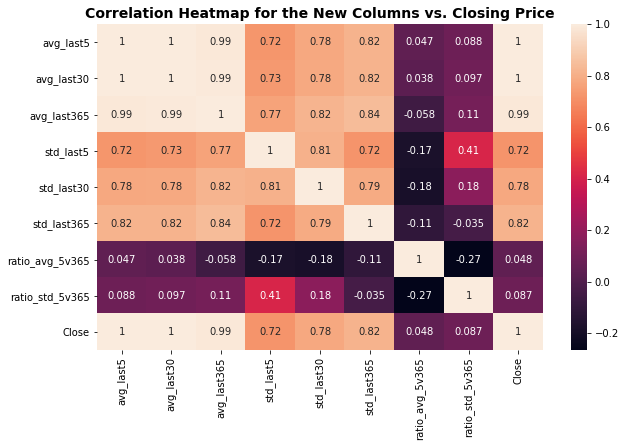

In [14]:
new_cols = ['avg_last5', 'avg_last30', 'avg_last365', 'std_last5',
        'std_last30', 'std_last365', 'ratio_avg_5v365', 'ratio_std_5v365', "Close"]

correlation = stocks_df[new_cols].corr()

fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(correlation, annot=True,)
plt.title("Correlation Heatmap for the New Columns vs. Closing Price",
          fontdict={"fontsize":14,
                    "fontweight":"bold"})


plt.show()

### Results

It seems like both of the ratio colums (average price and std. dev. for the last 5 days to 365 days) have weak correlations with the `Close` column. This infers that these columns will not be useful for our model. Let's test this by doing 1 iteration without them and 1 with them and see which one yields a higher adjusted R-Squared.

## Creating our model to predict `Close` price from 2013 to 2015

In [15]:
# Fit the lr model
features = ['avg_last5', 'avg_last30', 'avg_last365', 'std_last5',
           'std_last30', 'std_last365', 'ratio_avg_5v365', 'ratio_std_5v365']
target = "Close"

# With the ratio columns
X, y = stocks_df[features], stocks_df[target]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

# Without the ratio columns
X, y = stocks_df[features[:-2]], stocks_df[target]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.990e+06
Date:                Sat, 24 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:34:22   Log-Likelihood:                -62248.
No. Observations:               16225   AIC:                         1.245e+05
Df Residuals:                   16216   BIC:                         1.246e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5673      1.362     

### Results

According to the OLS regression we ran above, both models yielded an adjusted R-squared of 1; however, the ratio columns deemend as not statistically significant (the p-values being greater than 0.05). So, we can go ahead and drop these from our model.

In [16]:
lr = LinearRegression()

features = ['avg_last5', 'avg_last30', 'avg_last365', 'std_last5', 'std_last30', 'std_last365']
target = "Close"

# Creating our model
X_train, X_test = train[features], test[features]
y_train, y_test = train[target], test[target]

lr.fit(X_train, y_train)
train_predictions = lr.predict(X_train)

test_predictions = lr.predict(X_test)

mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)

# RESULTS
print("Features: {}".format(features))
print("RMSE: {}".format(rmse))

Features: ['avg_last5', 'avg_last30', 'avg_last365', 'std_last5', 'std_last30', 'std_last365']
RMSE: 22.203881310230788


## Adding more features to our model
Some other features we might want to consider:
- The day of week (Monday, Tuesday, etc.)
- The month
- Average volume over the past 5 days, 30 days, 365 days
- Average std dev. for volume over the past ...
- The highest close price in the past ...

There are many othe features we can create with this data, but for the simplicity of this project, we will continue with the ones listed above.

In [17]:
# Generating the Day of Week and Month
stocks_df["DOW"] = stocks_df["Date"].dt.day_name()
stocks_df["month"] = stocks_df["Date"].dt.month_name()
# Creating dummy cols because these features are categorical
dow_dummy = pd.get_dummies(stocks_df["DOW"])
month_dummy = pd.get_dummies(stocks_df["month"])

dummy = pd.concat([dow_dummy, month_dummy], 
                  axis=1)
stocks_df = pd.concat([stocks_df, dummy], 
                      axis=1)
stocks_df.drop(["DOW", "month"], 
               axis=1, 
               inplace=True)

In [18]:
# Generating the average and std. dev. volume for the past X days
# We can use the function we created earlier (calc_past_days)

# We are using stocks (instead of stocks_df) because stocks_df doesn't have all the dates that we need to calculate
stocks_df["volume_avg_5"] = calc_past_days(stocks, "Volume", 5, "mean").dropna()
stocks_df["volume_avg_30"] = calc_past_days(stocks, "Volume", 30, "mean").dropna()
stocks_df["volume_avg_365"] = calc_past_days(stocks, "Volume", 365, "mean").dropna()

stocks_df["volume_std_5"] = calc_past_days(stocks, "Volume", 5, "std").dropna()
stocks_df["volume_std_30"] = calc_past_days(stocks, "Volume", 30, "std").dropna()
stocks_df["volume_std_365"] = calc_past_days(stocks, "Volume", 365, "std").dropna()

In [19]:
# Generating the highest/lowest close price in the past X days

def calc_past_days(df, col, days, func):
    
    if func == "mean":
        result = df[col].rolling(days).mean().shift(1)
    elif func == "std":
        result = df[col].rolling(days).std().shift(1)
    elif func == "max":
        result = df[col].rolling(days).max().shift(1)
    elif func == "min":
        result = df[col].rolling(days).min().shift(1)
        
    return result

# Highest close price
stocks_df["highest_close_5"] = calc_past_days(stocks, "Close", 5, "max").dropna()
stocks_df["highest_close_30"] = calc_past_days(stocks, "Close", 30, "max").dropna()
stocks_df["highest_close_365"] = calc_past_days(stocks, "Close", 365, "max").dropna()

# Lowest close price
stocks_df["lowest_close_5"] = calc_past_days(stocks, "Close", 5, "min").dropna()
stocks_df["lowest_close_30"] = calc_past_days(stocks, "Close", 30, "min").dropna()
stocks_df["lowest_close_365"] = calc_past_days(stocks, "Close", 365, "min").dropna()


In [20]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16225 entries, 365 to 16589
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               16225 non-null  datetime64[ns]
 1   Open               16225 non-null  float64       
 2   High               16225 non-null  float64       
 3   Low                16225 non-null  float64       
 4   Close              16225 non-null  float64       
 5   Volume             16225 non-null  float64       
 6   Adj Close          16225 non-null  float64       
 7   Weekday            16225 non-null  float64       
 8   avg_last5          16225 non-null  float64       
 9   avg_last30         16225 non-null  float64       
 10  avg_last365        16225 non-null  float64       
 11  std_last5          16225 non-null  float64       
 12  std_last30         16225 non-null  float64       
 13  std_last365        16225 non-null  float64       
 14  rati

## Check correlation between new features 

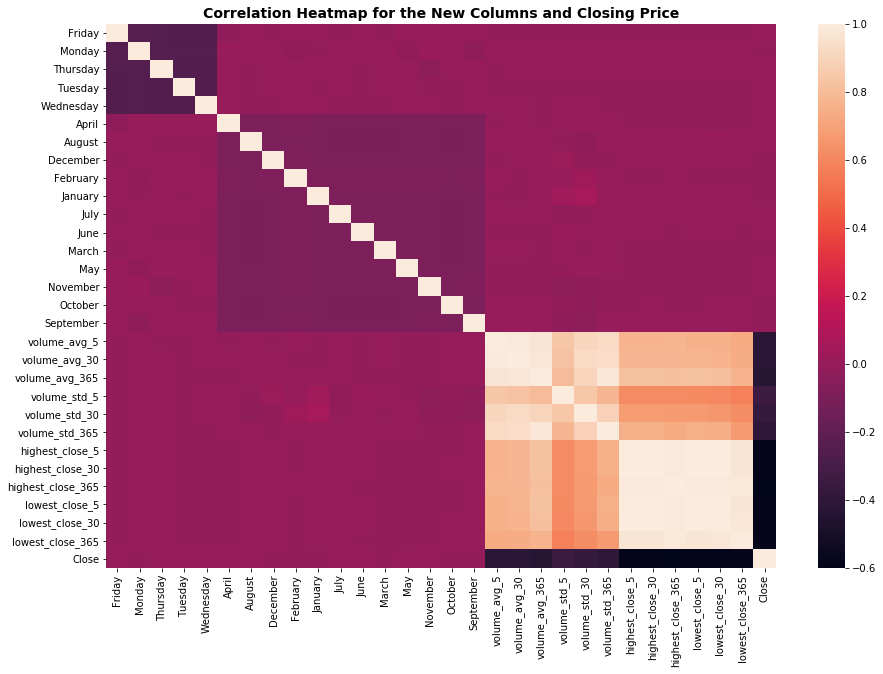

In [21]:
cols = ['Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday', 'April',
       'August', 'December', 'February', 'January', 'July', 'June', 'March',
       'May', 'November', 'October', 'September', 'volume_avg_5',
       'volume_avg_30', 'volume_avg_365', 'volume_std_5', 'volume_std_30',
       'volume_std_365', 'highest_close_5', 'highest_close_30',
       'highest_close_365', 'lowest_close_5', 'lowest_close_30',
       'lowest_close_365', 'Close']

correlation = stocks_df[cols].corr()

fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(correlation)
plt.title("Correlation Heatmap for the New Columns and Closing Price",
          fontdict={"fontsize":14,
                    "fontweight":"bold"})

plt.show()

### Results
It seems like all the new columns (volume average, volume standard deviation, highest closing price, and lowest closing price) have a strong negative correlation with the closing price. While the DOW and month have a weak positive correlation.

Let's see how they perform in our model.

## Creating our model with the new features

In [22]:
features = ['Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday', 'April',
            'August', 'December', 'February', 'January', 'July', 'June', 'March',
            'May', 'November', 'October', 'September', 'volume_avg_5',
            'volume_avg_30', 'volume_avg_365', 'volume_std_5', 'volume_std_30',
            'volume_std_365', 'highest_close_5', 'highest_close_30',
            'highest_close_365', 'lowest_close_5', 'lowest_close_30','lowest_close_365']
target = "Close"

# Model
X, y = stocks_df[features], stocks_df[target]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     373.0
Date:                Sat, 24 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:34:22   Log-Likelihood:            -1.2168e+05
No. Observations:               16225   AIC:                         2.434e+05
Df Residuals:                   16197   BIC:                         2.436e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               643.7453      3.77

### Results

The OLS regression with the newly added features yielded an adjusted R-Squared value of 38.2%, which isn't great. However, let's see how the model performs when we add the statistically significant features to the 1st model we created. 

In [23]:
lr = LinearRegression()

features = ['avg_last5', 'avg_last30', 'avg_last365', 'std_last5', 'std_last30', 'std_last365',
            'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday', 'April',
            'August', 'December', 'February', 'January', 'July', 'June', 'March',
            'May', 'November', 'October', 'September',
            'volume_avg_30', 'volume_avg_365', 'volume_std_5', 'volume_std_30',
            'volume_std_365', 'highest_close_365']
target = "Close"

# Model
X, y = stocks_df[features], stocks_df[target]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.480e+06
Date:                Sat, 24 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:34:22   Log-Likelihood:                -62231.
No. Observations:               16225   AIC:                         1.245e+05
Df Residuals:                   16197   BIC:                         1.247e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1971      0.16

In [24]:
pvalues = pd.Series(model.pvalues)

features = pvalues[pvalues < 0.05].index
target = "Close"

# Model
X, y = stocks_df[features], stocks_df[target]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.996e+06
Date:                Sat, 24 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:34:22   Log-Likelihood:                -62239.
No. Observations:               16225   AIC:                         1.245e+05
Df Residuals:                   16214   BIC:                         1.246e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1180      0.134      0.880      

### Results

For the final features, we are going to use the ones listed above. Let's see what RMSE the model yields.

In [25]:
# Train and test sets
train = stocks_df[stocks_df["Date"] < datetime.datetime(2013,1,1)]
test = stocks_df[stocks_df["Date"] >= datetime.datetime(2013,1,1)]

# Final features
features = model.params.index
features = features.drop("const")
# Target
target = "Close"

# Model
X_train, X_test = train[features], test[features]
y_train, y_test = train[target], test[target]

lr.fit(X_train, y_train)
train_predictions = lr.predict(X_train)

test_predictions = lr.predict(X_test)

# Calculate MAE, MSE, RMSE
mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)

# RESULTS
print("Features: {}".format(features))
print("RMSE: {}".format(rmse))

Features: Index(['avg_last5', 'avg_last30', 'avg_last365', 'std_last5', 'std_last30',
       'std_last365', 'August', 'December', 'October', 'September'],
      dtype='object')
RMSE: 22.17910095785401


## Making predictions for only 1 day ahead

For the models we have created thus far, we have been using about 95% of the data as our training set and about 5% for our testing set. This was because we tried to predict the stock prices from 2013 to 2015. What if we decided to only use the testing set to predict 1 day ahead?

For an example, if we want to predict the closing price for the stock on 2013-01-03, we create a training set from 1951-01-03 to 2013-01-02. This more closely simulates what you'd use for a day trading algorithm.

For each row, I want to calculate the RMSE given the test set is only 1 row.

In [26]:
stocks_df.reset_index(drop=True, inplace=True)

In [27]:
def train_test_1_day(data, features, target, start_date):
    
    df = data.copy()
    
    split_data = data[data["Date"] >= start_date]
    total_rmses = []
    for ix, row in split_data.iterrows():
        train = data.iloc[:ix]
        test = pd.DataFrame(row).transpose()

        lr = LinearRegression()
        lr.fit(train[features], train[target])
               
        test_predictions = lr.predict(test[features])
        
        mse = mean_squared_error(test[target], test_predictions)
        rmse = np.sqrt(mse)
        
        total_rmses.append(rmse)
        
    mean = np.mean(total_rmses)    
    print("You are making predictions for {} days.".format(split_data.shape[0]))
    print("Length of all RMSES: {}".format(len(total_rmses)))
    print("Average RMSE: {}".format(mean))
        
    return mean

In [28]:
features = ['avg_last5', 'avg_last30', 'avg_last365', 'std_last5', 'std_last30',
            'std_last365', 'August', 'September']

# Test our model
train_test_1_day(stocks_df, features, "Close", "2013-01-01")

You are making predictions for 739 days.
Length of all RMSES: 739
Average RMSE: 16.14165455132004


16.14165455132004

# Conclusion

## Summary
In this guided project, we worked with data from the S&P 500 Index. The goal of this project was to build a linear regression model to predict future prices. With these future prices, it can help us forecast how the stock market performs as a whole and even with economic forecasts (since the economy tends to correlate with how well the stock market performs). 

## Results
Out of all the features we created, we found that looking at the average prices and standard deviations for the past 5, 30, and 365 days, and the months August and September yielded the most accurate predictions (lowest RMSE of 22.17) One reason for the months August and September yielding better results may be because of the fiscal year ending in September. So, some investors may routinely cash in their earnings or reinvest for the next coming year. This is just an assumption.

Also, we found that predicting the closing price for only 1 day ahead yielded an even more accurate model with an average RMSE of 16.14 for all days ranging between 2013 and 2015. The reason for this was to better simulate what one would do in real life for day trading (However, this is not advised to do so with this model). 

## Next Steps
Based on our results, I would recommend looking at the averages and standard deviations of this specific index to make better predictions. 

To improve our model, we can include better indicators (features) to our model, try other techniques (such as random forest), incorporate outside data (e.g. Twitter activity around certain stocks), or even explore other stocks besides the S&P 500. The possibilities are endless.

#### Thank you for reading through this project! Open to any feedback :)

